In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import cv2
import os
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from math import inf
from keras.utils import to_categorical
import torch.nn.functional as F
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score


In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/video classification/x_train.npy')

x_test = np.load('/content/drive/MyDrive/Colab Notebooks/video classification/x_test.npy')

y_train = np.load('/content/drive/MyDrive/Colab Notebooks/video classification/y_train.npy')

y_test = np.load('/content/drive/MyDrive/Colab Notebooks/video classification/y_test.npy')

In [ ]:
y_train = to_categorical(y_train, 20)
y_test = to_categorical(y_test,20)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from torchmetrics import Accuracy

In [ ]:
train_accuracy = Accuracy(num_classes=20,task='multiclass').to(device)
test_accuracy = Accuracy(num_classes=20,task='multiclass').to(device)


In [ ]:

class VideoDataset(Dataset):
    def __init__(self, videos, labels):
        self.videos = videos
        self.labels = labels

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video = self.videos[idx]
        video = torch.from_numpy(video).float()  # Convert the video to a tensor and change dtype to torch.float32
        video = video.permute(0, 3, 1, 2)  # Change the dimensions to (timesteps, C, H, W)
        label = self.labels[idx]
        label = np.argmax(label)  # Convert one-hot encoded label to class index
        return video, label
batch_size = 10
train_dataset = VideoDataset(x_train, y_train)
test_dataset = VideoDataset(x_test, y_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
del x_train,x_test,y_train,y_test

In [ ]:

class VideoModel(nn.Module):
    def __init__(self, num_classes=20):
        super(VideoModel, self).__init__()

        self.slice_conv = nn.Sequential(
            nn.BatchNorm2d(3,momentum=0.8),
            nn.Conv2d(3, 20, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20,momentum=0.8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(30,momentum=0.8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(30, 30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.conv3d = nn.Sequential(
            nn.Conv3d(30, 50, kernel_size=3, padding=1),
            nn.BatchNorm3d(50,momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv3d(50, 60, kernel_size=3, padding=1),
            nn.BatchNorm3d(60,momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv3d(60, 70, kernel_size=3, padding=1),
            nn.BatchNorm3d(70,momentum=0.8),
            nn.ReLU(inplace=True)
        )

        self.gru1 = nn.GRU(input_size=32*48*70, hidden_size=1000, batch_first=True)
        self.gru2 = nn.GRU(input_size=1000, hidden_size=50, batch_first=True)

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Sequential(
            nn.Linear(50, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes)
        )



    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        conv_slices = []

        for t in range(timesteps):
            slice_t = x[:, t, :, :, :]
            slice_t = self.slice_conv(slice_t)
            conv_slices.append(slice_t)

        x = torch.stack(conv_slices, dim=2)
        x = self.conv3d(x)
        x = x.reshape(batch_size, timesteps, -1)
        x, _ = self.gru1(x)

        x, _ = self.gru2(x)

        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        return x



torch.manual_seed(0)


batch_size = 10

num_epochs = 30

best_sum_acc = 0.0
best_model_state = None


model = VideoModel(num_classes=20)
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.003)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for i, (videos, labels) in enumerate(train_loader):

        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(videos)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


        preds = outputs.argmax(dim=1)
#         acc = (preds == labels).float().mean()
#         train_acc += acc.item()
        acc = train_accuracy(outputs, labels)
        train_acc += acc.item()

        train_loss += loss.item()


    train_loss /= len(train_loader)
    train_acc /= len(train_loader)


    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for videos, labels in test_loader:

            videos, labels = videos.to(device), labels.to(device)


            outputs = model(videos)


            loss = criterion(outputs, labels)


            preds = outputs.argmax(dim=1)
            acc = test_accuracy(outputs, labels)
            test_acc += acc.item()


            test_loss += loss.item()


    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    current_sum_acc = train_acc + test_acc
    if current_sum_acc > best_sum_acc:
        best_sum_acc = current_sum_acc
        best_model_state = model.state_dict()
        print(f'Best model updated (Sum of Acc: {best_sum_acc*100:.2f}%)')


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%')
    torch.save(best_model_state, '/content/drive/MyDrive/Colab Notebooks/video classification/best_video_model.pth')

Best model updated (Sum of Acc: 27.15%)
Epoch 1/30, Train Loss: 2.9651, Train Acc: 8.43%, Test Loss: 2.8870, Test Acc: 18.72%
Best model updated (Sum of Acc: 48.14%)
Epoch 2/30, Train Loss: 2.8347, Train Acc: 18.47%, Test Loss: 2.7492, Test Acc: 29.67%
Best model updated (Sum of Acc: 62.34%)
Epoch 3/30, Train Loss: 2.6823, Train Acc: 26.39%, Test Loss: 2.5942, Test Acc: 35.95%
Best model updated (Sum of Acc: 71.98%)
Epoch 4/30, Train Loss: 2.5367, Train Acc: 33.38%, Test Loss: 2.4324, Test Acc: 38.60%
Best model updated (Sum of Acc: 77.54%)
Epoch 5/30, Train Loss: 2.3880, Train Acc: 37.08%, Test Loss: 2.3112, Test Acc: 40.45%
Best model updated (Sum of Acc: 87.42%)
Epoch 6/30, Train Loss: 2.2387, Train Acc: 43.24%, Test Loss: 2.1544, Test Acc: 44.18%
Best model updated (Sum of Acc: 89.67%)
Epoch 7/30, Train Loss: 2.0806, Train Acc: 47.92%, Test Loss: 2.1174, Test Acc: 41.75%
Best model updated (Sum of Acc: 90.87%)
Epoch 8/30, Train Loss: 1.9262, Train Acc: 50.97%, Test Loss: 2.1771, Te

In [ ]:
class VideoModel(nn.Module):
    def __init__(self, num_classes=20):
        super(VideoModel, self).__init__()

        self.slice_conv = nn.Sequential(
            nn.BatchNorm2d(3,momentum=0.8),
            nn.Conv2d(3, 20, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(20,momentum=0.8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(30,momentum=0.8),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(30, 30, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.conv3d = nn.Sequential(
            nn.Conv3d(30, 50, kernel_size=3, padding=1),
            nn.BatchNorm3d(50,momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv3d(50, 60, kernel_size=3, padding=1),
            nn.BatchNorm3d(60,momentum=0.8),
            nn.ReLU(inplace=True),
            nn.Conv3d(60, 70, kernel_size=3, padding=1),
            nn.BatchNorm3d(70,momentum=0.8),
            nn.ReLU(inplace=True)
        )

        self.gru1 = nn.GRU(input_size=32*48*70, hidden_size=1000, batch_first=True)
        self.gru2 = nn.GRU(input_size=1000, hidden_size=50, batch_first=True)

        self.dropout = nn.Dropout(0.5)

        self.fc = nn.Sequential(
            nn.Linear(50, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, num_classes)
        )



    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        conv_slices = []

        for t in range(timesteps):
            slice_t = x[:, t, :, :, :]
            slice_t = self.slice_conv(slice_t)
            conv_slices.append(slice_t)

        x = torch.stack(conv_slices, dim=2)
        x = self.conv3d(x)
        x = x.reshape(batch_size, timesteps, -1)
        x, _ = self.gru1(x)

        x, _ = self.gru2(x)

        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        return x

In [ ]:
batch_size = 10

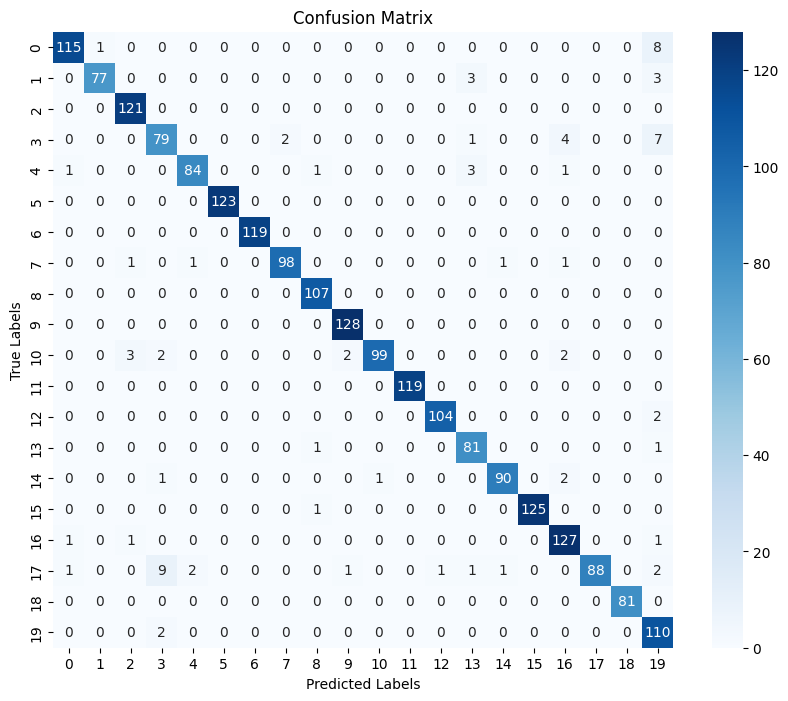

Precision: 0.9651
Recall: 0.9629
F1 Score: 0.9630


In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/video classification/best_video_model.pth'
saved_model = VideoModel(num_classes=20)
saved_model.load_state_dict(torch.load(model_path))

true_labels = []
predicted_labels = []

with torch.no_grad():
    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = saved_model(videos)
        preds = outputs.argmax(dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

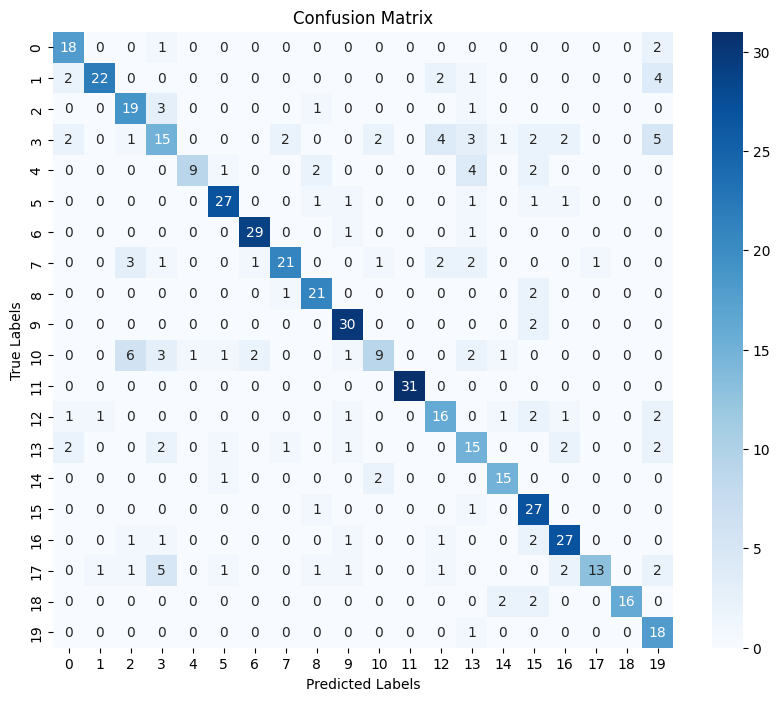

Precision: 0.7580
Recall: 0.7384
F1 Score: 0.7326


In [ ]:

true_labels = []
predicted_labels = []

with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = saved_model(videos)
        preds = outputs.argmax(dim=1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

In [ ]:
model
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 325980586


In [ ]:
def print_params(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()}")

print_params(model)

slice_conv.0.weight: 3
slice_conv.0.bias: 3
slice_conv.1.weight: 540
slice_conv.1.bias: 20
slice_conv.3.weight: 20
slice_conv.3.bias: 20
slice_conv.5.weight: 5400
slice_conv.5.bias: 30
slice_conv.7.weight: 30
slice_conv.7.bias: 30
slice_conv.9.weight: 8100
slice_conv.9.bias: 30
conv3d.0.weight: 40500
conv3d.0.bias: 50
conv3d.1.weight: 50
conv3d.1.bias: 50
conv3d.3.weight: 81000
conv3d.3.bias: 60
conv3d.4.weight: 60
conv3d.4.bias: 60
conv3d.6.weight: 113400
conv3d.6.bias: 70
conv3d.7.weight: 70
conv3d.7.bias: 70
gru1.weight_ih_l0: 322560000
gru1.weight_hh_l0: 3000000
gru1.bias_ih_l0: 3000
gru1.bias_hh_l0: 3000
gru2.weight_ih_l0: 150000
gru2.weight_hh_l0: 7500
gru2.bias_ih_l0: 150
gru2.bias_hh_l0: 150
fc.0.weight: 5000
fc.0.bias: 100
fc.2.weight: 2000
fc.2.bias: 20


In [ ]:
model

VideoModel(
  (slice_conv): Sequential(
    (0): BatchNorm2d(3, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (1): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(20, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(30, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (conv3d): Sequential(
    (0): Conv3d(30, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(50, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (2): ReLU(in